In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import seaborn as sns
sns.set()

path = '../Processed-Data/bon_03_06.nc'
replay = xr.open_dataset(path, 'CA1/replay_info').to_dataframe()

In [3]:
len(replay)

180

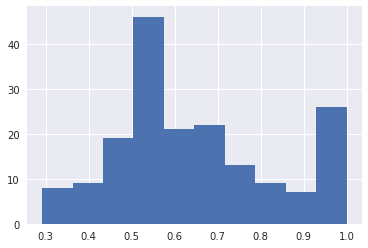

In [4]:
replay.predicted_state_probability.hist();

In [5]:
import numpy as np
np.mean(replay.predicted_state_probability >= .90)

0.15555555555555556

In [6]:
posterior_density = xr.open_dataset(path, 'CA1/posterior_density')
posterior_density['time'] = posterior_density.get_index('time').total_seconds()

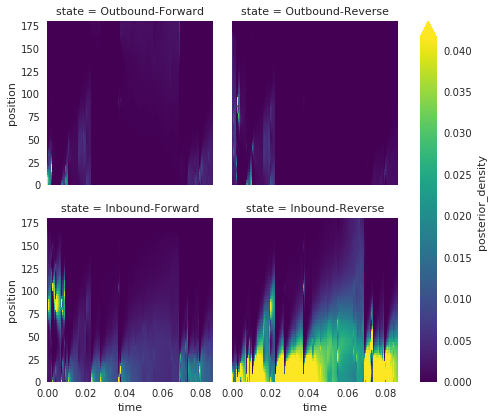

In [7]:
posterior_density.sel(ripple_number=11).posterior_density.dropna('time').plot(
    col='state', x='time', y='position', col_wrap=2, robust=True, vmin=0)

In [8]:
state_probability = xr.open_dataset(path, 'CA1/state_probability')

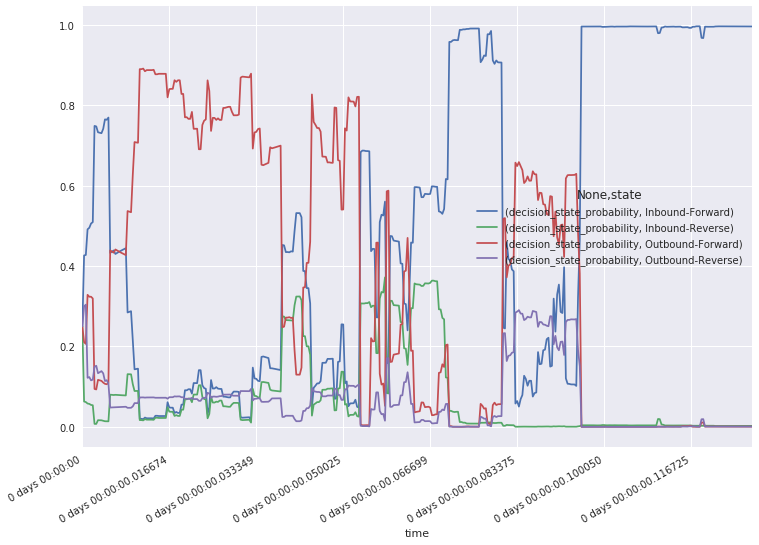

In [9]:
state_probability.sel(ripple_number=1).dropna('time').to_dataframe().drop('ripple_number', axis=1).unstack(level=0).plot(
    figsize=(12,9))

In [10]:
epoch_key = ('bon', 3, 6)
brain_areas = ['CA1']

In [11]:
from src.parameters import ANIMALS as animals
from loren_frank_data_processing import make_tetrode_dataframe

tetrode_info = make_tetrode_dataframe(animals).xs(
            epoch_key, drop_level=False)
tetrode_info

animal       area  day    depth descrip  \
animal day epoch tetrode_number                                           
bon    3   6     1                 bon        CA3    3  [[149]]     NaN   
                 2                 bon        CA3    3  [[151]]     NaN   
                 3                 bon        CA1    3  [[100]]     NaN   
                 4                 bon        CA1    3  [[107]]     NaN   
                 5                 bon        CA1    3  [[105]]     NaN   
                 6                 bon        NaN    3    [[0]]     NaN   
                 7                 bon        CA3    3  [[162]]     NaN   
                 8                 bon        CA3    3  [[153]]     NaN   
                 9                 bon        NaN    3      NaN     NaN   
                 10                bon        CA3    3  [[146]]     NaN   
                 11                bon        CA1    3   [[95]]     NaN   
                 12                bon        CA1    3  [[136]]     NaN   
                 13                bon        CA1    3   [[93]]     NaN   
                 14                bon        CA1    3   [[96]]     NaN   
                 15                bon        NaN    3    [[0]]     NaN   
                 16                bon        NaN    3      NaN     NaN   
                 17                bon        CA1    3  [[108]]     NaN   
                 18                bon        CA3    3  [[138]]     NaN   
                 19                bon        CA3    3  [[130]]     NaN   
                 20                bon        CA3    3  [[132]]     NaN   
                 21                bon        CA3    3  [[146]]     NaN   
                 22                bon        CA3    3  [[171]]     NaN   
                 23                bon        CA3    3  [[152]]     NaN   
                 24                bon        CA1    3  [[109]]     NaN   
                 25                bon        CA3    3  [[144]]     NaN   
                 26                bon        NaN    3      NaN     NaN   
                 27                bon        ???    3  [[157]]     NaN   
                 28                bon        CA1    3  [[100]]     NaN   
                 29                bon        CA1    3  [[118]]     NaN   
                 30                bon  Reference    3    [[0]]     NaN   

                                 epoch hemisphere  maxcell  nearCA2  numcells  \
animal day epoch tetrode_number                                                 
bon    3   6     1                   6      right      NaN      0.0       6.0   
                 2                   6      right      NaN      0.0       0.0   
                 3                   6      right      NaN      0.0       3.0   
                 4                   6      right      NaN      0.0       0.0   
                 5                   6      right      NaN      0.0       5.0   
                 6                   6        NaN      NaN      NaN       0.0   
                 7                   6      right      NaN      0.0       0.0   
                 8                   6      right      NaN      0.0       0.0   
                 9                   6        NaN      NaN      NaN       NaN   
                 10                  6      right      NaN      0.0       0.0   
                 11                  6      right      NaN      0.0       0.0   
                 12                  6       left      NaN      0.0       2.0   
                 13                  6       left      NaN      0.0       1.0   
                 14                  6       left      NaN      0.0       2.0   
                 15                  6        NaN      NaN      NaN       0.0   
                 16                  6        NaN      NaN      NaN       NaN   
                 17                  6       left      NaN      0.0       1.0   
                 18                  6       left      NaN      0.0       3.0   
           

In [12]:
is_brain_areas = tetrode_info.area.isin(brain_areas)
if 'CA1' in brain_areas:
    is_brain_areas = is_brain_areas & (
        tetrode_info.descrip.isin(['riptet']) | tetrode_info.validripple)
tetrode_keys = tetrode_info[is_brain_areas].index.tolist()
tetrode_keys

[('bon', 3, 6, 3),
 ('bon', 3, 6, 5),
 ('bon', 3, 6, 12),
 ('bon', 3, 6, 14),
 ('bon', 3, 6, 24),
 ('bon', 3, 6, 29)]

In [13]:
import pandas as pd
from loren_frank_data_processing import get_LFP_dataframe, get_interpolated_position_dataframe

hippocampus_lfps = pd.concat(
    [get_LFP_dataframe(tetrode_key, animals)
     for tetrode_key in tetrode_keys], axis=1)
time = hippocampus_lfps.index

def _time_function(epoch_key, animals):
    return time

speed = get_interpolated_position_dataframe(
    epoch_key, animals, _time_function).speed

In [14]:
from ripple_detection import Kay_ripple_detector, Karlsson_ripple_detector
from src.parameters import SAMPLING_FREQUENCY as sampling_frequency

kay_ripple_times = Kay_ripple_detector(
    time, hippocampus_lfps.values, speed.values, sampling_frequency,
    minimum_duration=pd.Timedelta(milliseconds=15), zscore_threshold=3)

karlsson_ripple_times = Karlsson_ripple_detector(
    time, hippocampus_lfps.values, speed.values, sampling_frequency,
    minimum_duration=pd.Timedelta(milliseconds=15), zscore_threshold=3)

In [15]:
print(len(kay_ripple_times), len(karlsson_ripple_times))

125 222


In [16]:
(kay_ripple_times.end_time - kay_ripple_times.start_time).min().total_seconds() * 1E3

35.851

In [17]:
(karlsson_ripple_times.end_time - karlsson_ripple_times.start_time).min().total_seconds() * 1E3

32.68300000000001

In [18]:
from src.analysis import decode_ripple_clusterless

kay_replay_info, _, _ = decode_ripple_clusterless(epoch_key, animals, kay_ripple_times)
karlsson_replay_info, _, _ = decode_ripple_clusterless(epoch_key, animals, karlsson_ripple_times)

/projectnb/braincom/edeno/conda_envs/Categorize_Replay_2017/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/projectnb/braincom/edeno/conda_envs/Categorize_Replay_2017/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


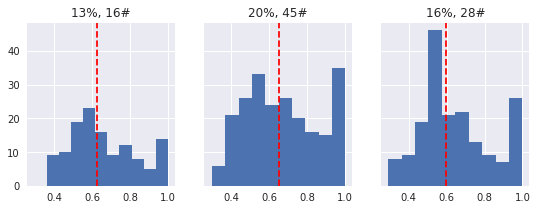

In [19]:
import matplotlib.pyplot as plt
state_prob = [kay_replay_info.predicted_state_probability,
              karlsson_replay_info.predicted_state_probability,
              replay.predicted_state_probability]

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

for ax, data in zip(axes, state_prob):
    data.hist(ax=ax)
    ax.axvline(data.median(), color='red', linestyle='--')
    ax.set_title('{0:.0f}%, {1}#'.format(np.mean(data >= .9) * 1E2, np.sum(data >= .9)))
